## Источник - https://hi-news.ru/

jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [1]:
import requests
from bs4 import BeautifulSoup

session = requests.session()

In [2]:
url = "https://hi-news.ru/"
req = session.get(url)

In [3]:
page = req.text

In [4]:
soup = BeautifulSoup(page, 'html.parser')

**1. Сначала получим список страниц. На каждой странице бывает около 10 постов с новостями. Попробуем поработать со списком в 100 страниц.**

Создадим список, в который положим ссылки страниц. Мы уже можем пополнить список первой страницей источника:

In [5]:
page_urls = [url]

Ссылки на страницы можно найти по классу page_link, но высветятся не все:

In [6]:
for link in soup.find_all('a', {'class': 'page-link'}):
    actualink = link.get('href')
    page_urls.append(actualink)

Также по такому поиску мы найдем две ссылки на вторую страницу. Находится она в конце, так что ее мы просто уберем:

In [7]:
if page_urls[-1] == page_urls[1]:
    del page_urls[-1]
page_urls

['https://hi-news.ru/',
 'https://hi-news.ru/page/2',
 'https://hi-news.ru/page/3',
 'https://hi-news.ru/page/4']

Теперь остается лишь перебор цифр, чтобы получить оставшиеся 96 страниц:

In [8]:
for page_number in range(5, 101):
    page = url + 'page/' + f'{page_number}'
    page_urls.append(page)

**2. Ищем статьи**

Создаем пустой список, чтобы потом поплнить его ссылками на статьи.

In [9]:
hn_articles = []

Открываем файл с ссылками на страницы, начинаем в каждой искать новости. В процессе поиска что-то переодически ломалось (кажется, попадались пустые ссылки), пришлось обратиться к *try except*.

In [10]:
for pu in page_urls:
    try:
        pu_response = requests.get(pu)
        pu_html_content = pu_response.text
        soupu = BeautifulSoup(pu_html_content, 'html.parser')
        here_links = soupu.find_all('h2', {'class': 'post__title post__title_preview'})
        for get_link in here_links:
            a = get_link.find('a')
            actualink = a.get('href')
            hn_articles.append(actualink)
    except:
        continue

Изначально длина списка **hn_articles** составила 2000, что естественно смутило меня. Поэтому было решено удалить возможные дубликаты, и потом картина все же приобрела смысл.

In [11]:
uniq_articles = list(set(hn_articles))

In [12]:
len(uniq_articles)

1000

Запишем список 1000 ссылок в отдельный файл:

In [13]:
with open("hn_articles.txt", "w", encoding = "utf-8") as f:
    for atcl in uniq_articles:
        f.write(atcl)
        f.write('\n')

**3. Ищем id, тескты, даты публикации, метки и темы статей**

Регулярки все же будут нужны. Например, при вытаскивании названий меток из одной ссылки, была получена следующая запись: *Стволовые клеткиЧеловечествоЭволюция человека*. Логично предположить, что так будет во всех остлаьных ссылках тоже. Поэтому попробуем разделить названия при помощи регулярок.

In [2]:
import re

In [12]:
dates = []
texts = []
themes = []
alltags = []

In [13]:
def searching_date(some_soup):
    date_here = atcl_soup.find('div', {'class': 'info'})
    date = re.search(r'\d{2}.\d{2}.\d{4}', date_here.text)
    return date.group(0)

In [14]:
def searching_text(some_soup):
    tekst_here = atcl_soup.find('div', {'class': 'text'})
    tekst = tekst_here.text
    return tekst

In [15]:
def searching_theme(some_soup):
    itemprops = atcl_soup.find_all('span', itemprop="name") #находит 3 элемента, в последнем лежит название темы
    theme = itemprops[2]
    theme_name = theme.text #получаем название темы
    return theme_name

In [16]:
def searching_tags(some_soup):
    here_tags = atcl_soup.find_all('div', {'class': 'tags'})#находит строчки, где содержатся метки
    for get_tags in here_tags:
        tags = get_tags.text
        divd_tags = re.sub(r'([а-я])([А-Я])', r'\1/\2', tags)
        return divd_tags

В коде ниже открывается файл с ссылками на статьи. В каждой ссылке мы вытаскиваем информацию о дате, тексте, теме, метках статьи. Затем пополняем полученными данными раннее созданные списки *dates, texts, themes* и *alltags.* Работа выполняется в цикле, удобно использовать *try-except*, благодаря которому не прервется обработка. Что немного странно, что вероятно возникла единственная ошибка, но в какой ссылке — непонятно.

In [62]:
%%time
with open("hn_articles.txt", "r", encoding = "utf-8") as f:
    articles = f.read()
    articles = articles.split('\n')
    
    for one_article in articles:
        try:
            atcl_response = requests.get(one_article)
            atcl_html_content = atcl_response.text
            atcl_soup = BeautifulSoup(atcl_html_content, 'html.parser')

            hn_date = searching_date(atcl_soup)
            hn_text = searching_text(atcl_soup)
            hn_theme = searching_theme(atcl_soup)
            hn_tags = searching_tags(atcl_soup)

            dates.append(hn_date)
            texts.append(hn_text)
            themes.append(hn_theme)
            alltags.append(hn_tags)

        except:
            print(f"Something went wrong while parsing {one_article}")


Something went wrong while parsing 
Wall time: 7min 51s


**3'. Правки и дополнения в списках**

Хотя регулярки во многом исправили положение дел, приведя строчку *Стволовые клеткиЧеловечествоЭволюция человека* к *Стволовые клетки/Человечество/Эволюция человека*, остались некоторые недоработки с метками на английском. Поскольку у нас уже есть файл с данными, я буду исправлять что-то в нем, чтобы не запускать парсинг каждый раз.

In [19]:
for tag_line in alltags:       
    if 'Tesla' in tag_line:
        if 'Tesla Model 3' in tag_line:
            tag_line = tag_line.replace('Tesla Model 3', 'Tesla Model 3/')
        else:
            tag_line = tag_line.replace('Tesla', 'Tesla/')
    if 'NASA' in tag_line:
        tag_line = tag_line.replace('NASA', 'NASA/')
    if 'sТ' in tag_line:
        tag_line = tag_line.replace('sТ', 's/Т')
    if 'SpaceX' in tag_line:
        tag_line = tag_line.replace('SpaceX', 'SpaceX/')
    if 'DIA' in tag_line:
        tag_line = tag_line.replace('DIA', 'DIA/')                            
    if 'Windows' in tag_line:
        tag_line = tag_line.replace('Windows', 'Windows/')    
    if 'Galactic' in tag_line:
        tag_line = tag_line.replace('Galactic', 'Galactic/')
    if 'DARPA' in tag_line:
        tag_line = tag_line.replace('DARPA','DARPA/')
    if 'Dragon' in tag_line:
        tag_line = tag_line.replace('Dragon','Dragon/')
    if 'loop' in tag_line:
        tag_line = tag_line.replace('loop','loop/')

Разбиение полной даты:

In [20]:
DDs = []
MMs = []
YYYYs = []

In [21]:
for full_date in dates:
    ddmmyy = full_date.split('.')
    DDs.append(ddmmyy[0])
    MMs.append(ddmmyy[1])
    YYYYs.append(ddmmyy[2])

Создаем список id:

In [23]:
ids = []
for i in range(1000):
    ids.append(i)

**4. Создание таблиц**

In [8]:
import pandas as pd

Сначала создадим таблицу с основной информацией про id текста, дату и сам текст:

In [42]:
main_data = {
    "id": ids,
    "Date": DDs,
    "Month": MMs,
    "Year": YYYYs,
    "Text": texts
}

main_df = pd.DataFrame(main_data)
main_df

,id,Date,Month,Year,Text
0,0,15,06,2020,Сегодня крокодилы обитают в тропических район...
1,1,12,07,2020,Тысячи лет назад люди кормили и ухаживали за ...
2,2,19,04,2020,Приспосабливайся или умри – вот основной прин...
3,3,18,07,2020,Практически во всех уголках нашей планеты жив...
4,4,05,09,2020,Президенты разных стран мира вынуждены часто ...
...,...,...,...,...,...
995,995,24,06,2020,С тех пор как в 2017 году был открыт астероид...
996,996,14,04,2020,В мире существуют сотни разных флагов. Все он...
997,997,02,04,2020,"Одной из главных проблем, связанных с распрос..."
998,998,09,09,2020,"Многие из нас слышали, что cидячий образ жизн..."


Теперь создадим таблицу с дополнительной информацией про метки и темы статей. Тут же будут лежать id, по которым мы сможем соединить *main_df* и *add_df*.

In [43]:
add_data = {
    "text_id": ids,
    "tags": alltags,
    "topic": themes
}

add_df = pd.DataFrame(add_data)
add_df

,text_id,tags,topic
0,0,Археология/Динозавры/Животные Земли,Это интересно
1,1,Археология/Животные Земли,Это интересно
2,2,Животные Земли/Климат на Земле,Это интересно
3,3,Животные Земли/Загадки природы,Это интересно
4,4,История технологий/Самолеты,Технологии
...,...,...,...
995,995,Астероиды/Дальний космос/Загадки космоса,Исследования
996,996,История технологий/Луна,Исследования
997,997,Вирусы/Коронавирус/Медицина,Это интересно
998,998,Здоровье человека/Медицина/Человечество,Исследования


**4.2. Формирование БД**

In [1]:
import sqlite3

Создаем БД:

In [3]:
conn = sqlite3.connect('Hi_news.db')
c = conn.cursor()

Создаем в БД таблицы *main_data* и *additional_data*. Чтобы заполнить их, мы переводим соответствующие таблицы pandas в sql:

In [102]:
c.execute('CREATE TABLE main_data (id, Date, Month, Year, Text)')
conn.commit()

In [103]:
main_df.to_sql('main_data', conn, if_exists='replace', index = False)

In [104]:
c.execute('CREATE TABLE additional_data (text_id, tags, topic)')
conn.commit()

In [105]:
add_df.to_sql('additional_data', conn, if_exists='replace', index = False)

Создаем общую таблицу с информацией об id, тексте, метках, теме и дате статей.

In [5]:
full_data_query = """
SELECT text_id, Text, tags, topic, Date, Month, Year
FROM main_data
    JOIN additional_data ON main_data.id = additional_data.text_id
"""

In [6]:
c.execute(full_data_query)

In [9]:
fulldf = pd.DataFrame(c.fetchall(), columns=['text_id', 'Text', 'tags', 'topic', 'Date', 'Month', 'Year'])
fulldf

,text_id,Text,tags,topic,Date,Month,Year
0,0,Сегодня крокодилы обитают в тропических район...,Археология/Динозавры/Животные Земли,Это интересно,15,06,2020
1,1,Тысячи лет назад люди кормили и ухаживали за ...,Археология/Животные Земли,Это интересно,12,07,2020
2,2,Приспосабливайся или умри – вот основной прин...,Животные Земли/Климат на Земле,Это интересно,19,04,2020
3,3,Практически во всех уголках нашей планеты жив...,Животные Земли/Загадки природы,Это интересно,18,07,2020
4,4,Президенты разных стран мира вынуждены часто ...,История технологий/Самолеты,Технологии,05,09,2020
...,...,...,...,...,...,...,...
995,995,С тех пор как в 2017 году был открыт астероид...,Астероиды/Дальний космос/Загадки космоса,Исследования,24,06,2020
996,996,В мире существуют сотни разных флагов. Все он...,История технологий/Луна,Исследования,14,04,2020
997,997,"Одной из главных проблем, связанных с распрос...",Вирусы/Коронавирус/Медицина,Это интересно,02,04,2020
998,998,"Многие из нас слышали, что cидячий образ жизн...",Здоровье человека/Медицина/Человечество,Исследования,09,09,2020


In [10]:
c.execute('CREATE TABLE full_data (text_id,Text,tags,topic,Date,Month,Year)')
conn.commit()

In [11]:
fulldf.to_sql('full_data', conn, if_exists='replace', index = False)

**5. Всякая статистика и ее визуализация**

**5.1. Облако словоформ из текстов статей**

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [49]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words('russian')+['но', 'на', 'это', 'весь', 'который', 'мочь', 'свой'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ксюша\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
text = ' '.join([word for word in fulldf['Text'].values if word not in stopwords])

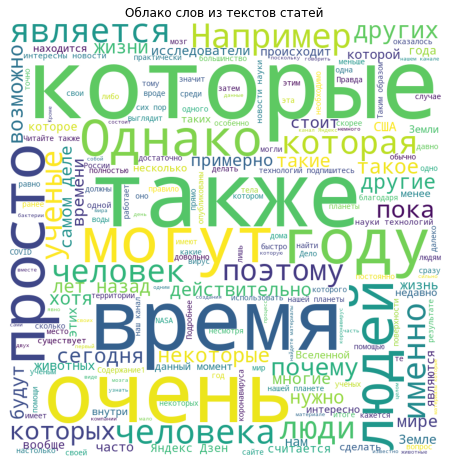

In [51]:
wordcloud = WordCloud(stopwords=stopwords,
    background_color ='white',
    width = 800,
    height = 800, 
).generate(text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов из текстов статей')
plt.show()

**5.2. В каком году сколько статей**

Нужно иметь в виду, что данная статистика не может быть полной, ведь мы собрали всего 1000 статей.

In [84]:
import collections

m_times = []
months = list(months_counter.keys())
months.sort()
for month in months:
    m_times.append(months_counter[month])

In [85]:
m_names = ['Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь']

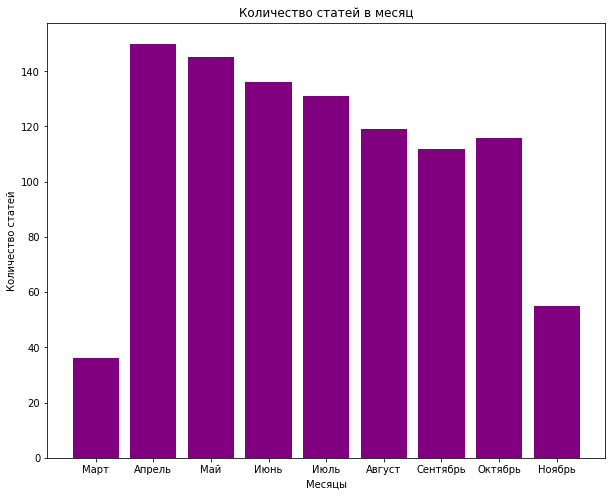

In [86]:
plt.figure(figsize = (10, 8)) 
plt.bar(months, m_times, color = 'purple')
plt.xticks(ticks = months, labels = m_names)
plt.title('Количество статей в месяц')
plt.ylabel('Количество статей')
plt.xlabel('Месяцы')
plt.show()